In [4]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from ann_visualizer.visualize import ann_viz
#from sklearn.datasets import make_regression
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import json

ModuleNotFoundError: No module named 'ann_visualizer'

In [2]:
'''Import data'''

# File path
data = h5py.File('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/JB2008_1999_2010_ROM_r100.mat', 'r')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data)

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()
print(sw_data.shape)
sw_col_names = ["doy", "UThrs", "F10", "F10B", "S10", "S10B", "XM10", "XM10B", "Y10", "Y10B", "DSTDTC", "GWRAS", "SUN(1)", "SUN(2)"]
df = pd.DataFrame(sw_data, columns = sw_col_names)
print(df.head())

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]


'''Training data'''
# Training input

# Testing the 70, 15, 15 for train, val, test 

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15,:]
sw_data_train = sw_data[0:split_15,:]
sw_data_train_append = sw_data[1:split_15+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)

# TODO: we could also add the SW data of the next time step if that perform better

# Training output
# Output is reduced-order density data at next time step
y_train = dens_data[1:split_15+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
print(dens_data.shape)
dens_data_test = dens_data[split_15:-1,:]
sw_data_test = sw_data[split_15:-1,:]
sw_data_test_append = sw_data[split_15+1:,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
print(sw_data_test.shape)
print(dens_data_test.shape)
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)
print(x_test.shape)
print(x_test[0])

# Test output
# Output is reduced-order density data at next time step
y_test = dens_data[split_15+1:,:]


print(x_test.shape)


(103404, 14)
    doy  UThrs    F10   F10B    S10   S10B   XM10  XM10B    Y10   Y10B  \
0  75.0   12.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
1  75.0   13.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
2  75.0   14.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
3  75.0   15.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
4  75.0   16.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   

   DSTDTC     GWRAS    SUN(1)    SUN(2)  
0    17.5  6.172181 -0.072585 -0.031433  
1    38.5  0.151512 -0.071919 -0.031146  
2    38.5  0.414028 -0.071254 -0.030859  
3    38.5  0.676544 -0.070589 -0.030571  
4    38.5  0.939060 -0.069923 -0.030284  
(103404, 10)
(15510, 28)
(15510, 10)
(15510, 38)
[ 9.27667930e+01  4.29096938e-02  8.27743391e-01  2.57601031e+00
 -7.66075021e-02  2.83963270e-01 -1.66493264e-01  6.05069019e-01
 -3.45673029e-01  3.60885127e-02  8.40000000e+01  1.70000000e+01
  6.91000000e+01  6.96000000e+01  4.76000000e+

In [3]:
with open('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/recurrent_model.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/recurrent_model.h5')
model_NN.summary()


with open('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/model.json','r') as f:
    model_NN_json_1 = json.load(f)
    model_NN_json_1 = json.dumps(model_NN_json_1)
    model_NN_json_1 = str(model_NN_json_1)

model_NN_1 = model_from_json(model_NN_json_1)
model_NN_1.load_weights('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/model.h5')
model_NN_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               4680      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [4]:
loaded_prediction = model_NN.predict(x_test)
loaded_prediction_1 = model_NN_1.predict(x_test)
error = np.sum(np.square(loaded_prediction-y_test))/(loaded_prediction.shape[0]*loaded_prediction.shape[1])
error_1 = np.sum(np.square(loaded_prediction_1-y_test))/(loaded_prediction_1.shape[0]*loaded_prediction_1.shape[1])

print(error, error_1)

0.0012480140358716698 0.0010112864999005907


In [5]:
'''RANDOM SPLITTING FOR TEST DATA '''
dens_data_train = dens_data[0:-1,:]
sw_data_train = sw_data[0:-1,:]
sw_data_train_append = sw_data[1:,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)

y_train = dens_data[1:,:]

'''Test data'''
# Test input
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)
sw_data_test = x_test[:,:28]
dens_data_test = x_test[:,28:]
print(dens_data_test.shape)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647)
print(sw_data_test.shape)

(15511, 10)
(15511, 28)


In [14]:
'''Create NN'''
def swish(x, beta=1.0):
    return x * K.sigmoid(beta * x)

def leaky_relu6(x):
    return K.relu(x, alpha = 0.3)

model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
#kernel_regularizer=regularizers.l2(0.01)
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('tanh'))
model.add(Dense(40, kernel_initializer='random_uniform'))
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('sigmoid'))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))



In [6]:
#def leaky_relu6(x):
 #   return max(K.relu(x, alpha = 0.3), 6)

#rel = activations.relu(x, alpha=0.3, max_value=6)

test_model = Sequential()
test_model.add(Dense(80, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 6, alpha=0.3)))
test_model.add(Dense(40, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 100, alpha=0.3)))
test_model.add(Dense(20, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 10, alpha=0.3)))
test_model.add(Dense(10, kernel_initializer='random_uniform'))
ad = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
test_model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
history = test_model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 16) #, callbacks=[early_stop])


Train on 72381 samples, validate on 15511 samples
Epoch 1/500
72381/72381 [==============================] - 5s 68us/step - loss: 15.4609 - accuracy: 0.9349 - val_loss: 0.6808 - val_accuracy: 0.9732
Epoch 2/500
72381/72381 [==============================] - 5s 63us/step - loss: 0.5197 - accuracy: 0.9756 - val_loss: 0.3850 - val_accuracy: 0.9729
Epoch 3/500
72381/72381 [==============================] - 5s 69us/step - loss: 0.3519 - accuracy: 0.9754 - val_loss: 0.3614 - val_accuracy: 0.9756
Epoch 4/500
72381/72381 [==============================] - 5s 63us/step - loss: 0.2468 - accuracy: 0.9808 - val_loss: 0.2132 - val_accuracy: 0.9824
Epoch 5/500
72381/72381 [==============================] - 5s 73us/step - loss: 0.1848 - accuracy: 0.9842 - val_loss: 0.1668 - val_accuracy: 0.9848
Epoch 6/500
72381/72381 [==============================] - 5s 71us/step - loss: 0.1462 - accuracy: 0.9864 - val_loss: 0.1067 - val_accuracy: 0.9833
Epoch 7/500
72381/72381 [==============================] - 5s

Epoch 56/500
72381/72381 [==============================] - 4s 59us/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0501 - val_accuracy: 0.9961
Epoch 57/500
72381/72381 [==============================] - 4s 58us/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0262 - val_accuracy: 0.9939
Epoch 58/500
72381/72381 [==============================] - 4s 59us/step - loss: 0.0231 - accuracy: 0.9955 - val_loss: 0.0208 - val_accuracy: 0.9970
Epoch 59/500
72381/72381 [==============================] - 5s 69us/step - loss: 0.0214 - accuracy: 0.9952 - val_loss: 0.0368 - val_accuracy: 0.9950
Epoch 60/500
72381/72381 [==============================] - 5s 69us/step - loss: 0.0226 - accuracy: 0.9949 - val_loss: 0.0175 - val_accuracy: 0.9965
Epoch 61/500
72381/72381 [==============================] - 5s 64us/step - loss: 0.0217 - accuracy: 0.9945 - val_loss: 0.0140 - val_accuracy: 0.9932
Epoch 62/500
72381/72381 [==============================] - 5s 68us/step - loss: 0.0224 - accuracy: 0.9953

Epoch 111/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.0235 - val_accuracy: 0.9910
Epoch 112/500
72381/72381 [==============================] - 4s 60us/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0109 - val_accuracy: 0.9976
Epoch 113/500
72381/72381 [==============================] - 4s 56us/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.0346 - val_accuracy: 0.9949
Epoch 114/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 0.0285 - val_accuracy: 0.9945
Epoch 115/500
72381/72381 [==============================] - 4s 55us/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.0132 - val_accuracy: 0.9968
Epoch 116/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0078 - val_accuracy: 0.9974
Epoch 117/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0139 - accuracy:

Epoch 220/500
72381/72381 [==============================] - 4s 53us/step - loss: 0.0096 - accuracy: 0.9966 - val_loss: 0.0053 - val_accuracy: 0.9983
Epoch 221/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0150 - val_accuracy: 0.9960
Epoch 222/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0169 - val_accuracy: 0.9962
Epoch 223/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0190 - val_accuracy: 0.9952
Epoch 224/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0099 - accuracy: 0.9966 - val_loss: 0.0084 - val_accuracy: 0.9977
Epoch 225/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0108 - val_accuracy: 0.9968
Epoch 226/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0097 - accuracy:

72381/72381 [==============================] - 4s 51us/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 0.0024 - val_accuracy: 0.9976
Epoch 329/500
72381/72381 [==============================] - 4s 50us/step - loss: 0.0081 - accuracy: 0.9968 - val_loss: 0.0034 - val_accuracy: 0.9981
Epoch 330/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0079 - accuracy: 0.9968 - val_loss: 0.0079 - val_accuracy: 0.9952
Epoch 331/500
72381/72381 [==============================] - 4s 60us/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 0.0085 - val_accuracy: 0.9979
Epoch 332/500
72381/72381 [==============================] - 4s 58us/step - loss: 0.0076 - accuracy: 0.9968 - val_loss: 0.0031 - val_accuracy: 0.9975
Epoch 333/500
72381/72381 [==============================] - 4s 60us/step - loss: 0.0073 - accuracy: 0.9967 - val_loss: 0.0065 - val_accuracy: 0.9969
Epoch 334/500
72381/72381 [==============================] - 4s 56us/step - loss: 0.0075 - accuracy: 0.9970 - val_

Epoch 383/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0070 - accuracy: 0.9969 - val_loss: 0.0077 - val_accuracy: 0.9970
Epoch 384/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0027 - val_accuracy: 0.9981
Epoch 385/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0073 - accuracy: 0.9969 - val_loss: 0.0033 - val_accuracy: 0.9977
Epoch 386/500
72381/72381 [==============================] - 4s 50us/step - loss: 0.0083 - accuracy: 0.9968 - val_loss: 0.0097 - val_accuracy: 0.9977
Epoch 387/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0078 - accuracy: 0.9971 - val_loss: 0.0109 - val_accuracy: 0.9945
Epoch 388/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.0114 - val_accuracy: 0.9950
Epoch 389/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0074 - accuracy:

Epoch 492/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0066 - accuracy: 0.9972 - val_loss: 0.0247 - val_accuracy: 0.9946
Epoch 493/500
72381/72381 [==============================] - 4s 52us/step - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0065 - val_accuracy: 0.9971
Epoch 494/500
72381/72381 [==============================] - 4s 50us/step - loss: 0.0064 - accuracy: 0.9969 - val_loss: 0.0105 - val_accuracy: 0.9936
Epoch 495/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 0.0058 - val_accuracy: 0.9926
Epoch 496/500
72381/72381 [==============================] - 4s 50us/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.0084 - val_accuracy: 0.9963
Epoch 497/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0062 - accuracy: 0.9970 - val_loss: 0.0033 - val_accuracy: 0.9979
Epoch 498/500
72381/72381 [==============================] - 4s 51us/step - loss: 0.0069 - accuracy:

Train on 72381 samples, validate on 15511 samples
Epoch 1/200
72381/72381 [==============================] - 4s 56us/step - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.0049 - val_accuracy: 0.9974
Epoch 2/200
72381/72381 [==============================] - 4s 54us/step - loss: 0.0061 - accuracy: 0.9971 - val_loss: 0.0036 - val_accuracy: 0.9977
Epoch 3/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0053 - accuracy: 0.9972 - val_loss: 0.0035 - val_accuracy: 0.9974
Epoch 4/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0060 - accuracy: 0.9973 - val_loss: 0.0032 - val_accuracy: 0.9975
Epoch 5/200
72381/72381 [==============================] - 4s 53us/step - loss: 0.0058 - accuracy: 0.9973 - val_loss: 0.0051 - val_accuracy: 0.9956
Epoch 6/200
72381/72381 [==============================] - 4s 54us/step - loss: 0.0058 - accuracy: 0.9975 - val_loss: 0.0078 - val_accuracy: 0.9966
Epoch 7/200
72381/72381 [==============================] - 4s 

Epoch 56/200
72381/72381 [==============================] - 5s 62us/step - loss: 0.0053 - accuracy: 0.9975 - val_loss: 0.0088 - val_accuracy: 0.9957
Epoch 57/200
72381/72381 [==============================] - 5s 67us/step - loss: 0.0050 - accuracy: 0.9973 - val_loss: 0.0045 - val_accuracy: 0.9979
Epoch 58/200
72381/72381 [==============================] - 5s 73us/step - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.0153 - val_accuracy: 0.9914
Epoch 59/200
72381/72381 [==============================] - 6s 82us/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0037 - val_accuracy: 0.9985
Epoch 60/200
72381/72381 [==============================] - 5s 73us/step - loss: 0.0050 - accuracy: 0.9975 - val_loss: 0.0042 - val_accuracy: 0.9954
Epoch 61/200
72381/72381 [==============================] - 5s 63us/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0.0027 - val_accuracy: 0.9976
Epoch 62/200
72381/72381 [==============================] - 4s 59us/step - loss: 0.0057 - accuracy: 0.9973

Epoch 111/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0047 - accuracy: 0.9975 - val_loss: 0.0013 - val_accuracy: 0.9988
Epoch 112/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0046 - accuracy: 0.9979 - val_loss: 0.0064 - val_accuracy: 0.9975
Epoch 113/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0049 - accuracy: 0.9976 - val_loss: 0.0021 - val_accuracy: 0.9984
Epoch 114/200
72381/72381 [==============================] - 4s 51us/step - loss: 0.0043 - accuracy: 0.9978 - val_loss: 0.0023 - val_accuracy: 0.9977
Epoch 115/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0048 - accuracy: 0.9978 - val_loss: 0.0047 - val_accuracy: 0.9966
Epoch 116/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0047 - accuracy: 0.9975 - val_loss: 0.0015 - val_accuracy: 0.9988
Epoch 117/200
72381/72381 [==============================] - 4s 52us/step - loss: 0.0045 - accuracy:

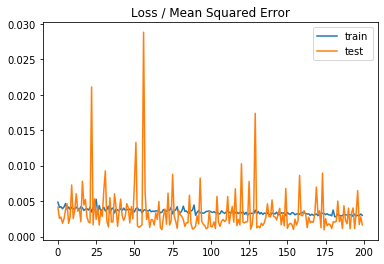

In [19]:
'''Train NN'''
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#early_stop = EarlyStopping(patience=5)
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647, random_state=42)
#history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 32) #, callbacks=[early_stop])
#validation_data=(x_test, y_test)
history2 = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 16)
#validation_split=0.25
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [23]:
model_saved = test_model.save("")


model_json = test_model.to_json()
with open("LeakyReluCapModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
test_model.save_weights("LeakyReluCapModel.h5")
print("Saved model")



Saved model


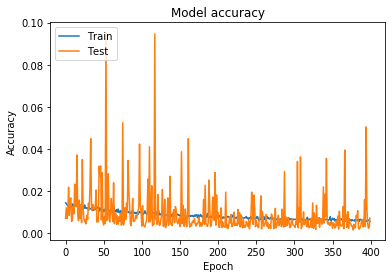

'\nmodel_json = test_model.to_json()\nwith open("test_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("test_model.h5")\nprint("Saved model")\n\n\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model.h5")\nprint("Saved model")\n'

In [26]:
'''HISTORY PLOTS'''

plt.figure()
plt.plot(history.history['loss'][100:])
plt.plot(history.history['val_loss'][100:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

'''
model_json = test_model.to_json()
with open("test_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("test_model.h5")
print("Saved model")


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model")
'''

72381/72381 [==============================] - 1s 9us/step
[0.007036531061227742, 0.9972091913223267]
15511/15511 [==============================] - 0s 10us/step
[0.007210008912579826, 0.9970988035202026]


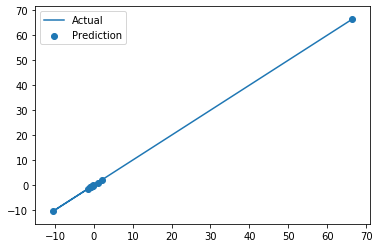

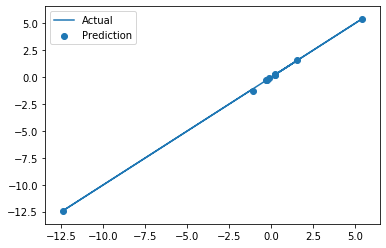

In [21]:
'''
plt.figure()
plt.plot(y_train[20],y_train[20],label="Actual")
plt.scatter(y_train[20],model.predict(x_train)[20],label="Prediction")
plt.legend()

print(model.evaluate(x_train,y_train,batch_size=32, verbose=1))

plt.figure()
plt.plot(y_test[20],y_test[20],label="Actual")
plt.scatter(y_test[20],model.predict(x_test)[20],label="Prediction")
plt.legend()

print(model.evaluate(x_test,y_test,batch_size=32, verbose=1))
'''

'''Test performance NN leakyrelu6'''
plt.figure()
plt.plot(y_train[20],y_train[20],label="Actual")
plt.scatter(y_train[20],test_model.predict(x_train)[20],label="Prediction")
plt.legend()

print(test_model.evaluate(x_train,y_train,batch_size=32, verbose=1))

plt.figure()
plt.plot(y_test[20],y_test[20],label="Actual")
plt.scatter(y_test[20],test_model.predict(x_test)[20],label="Prediction")
plt.legend()

print(test_model.evaluate(x_test,y_test,batch_size=32, verbose=1))


0.00176736997957367
(15511, 10)
0.0011994017207523587
10

12824.42666874957
10


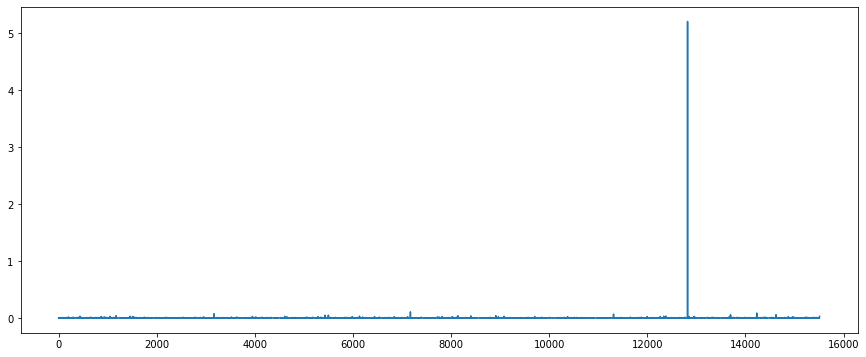

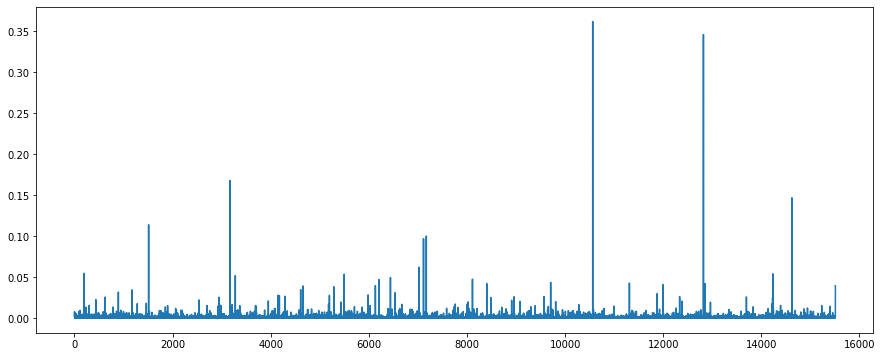

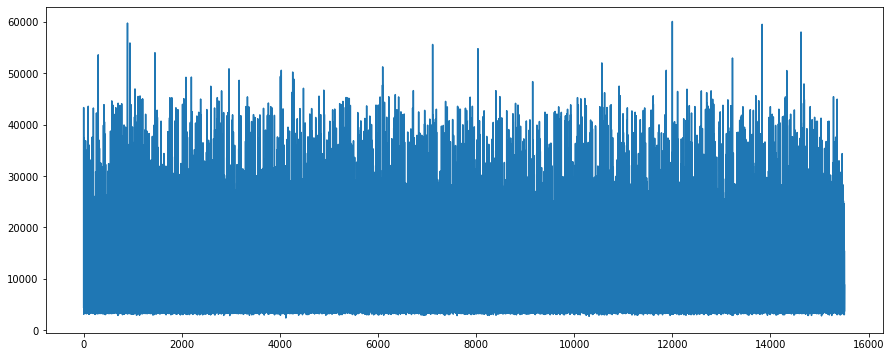

In [21]:
'''Testing NN vs ROM using same error metric'''

# NN

y_pred = model.predict(x_test)
#print(y_pred.shape)
#print(x_test.shape)

mse = np.sum(np.square(y_pred-y_test))/(y_pred.shape[0]*y_pred.shape[1])
print(mse)
y_pred_error = abs(y_pred-y_test)
print(y_pred_error.shape)
mse2 = np.zeros(y_pred_error.shape[0])
#print(len(y_pred_error[0]))
for i in range(len(y_pred_error)):
    for j in range(len(y_pred_error[0])):
        mse2[i] += y_pred_error[i][j]**2
    mse2[i] = mse2[i]/(y_pred_error.shape[1])
    
plt.figure(figsize=(15,6))
plt.plot(mse2)


# NN LeakyRelu6
y_pred = test_model.predict(x_test)
#print(y_pred.shape)
#print(x_test.shape)
mse = 0
for i in range(len(y_pred)):
    for j in range(len(y_pred[0])):
        mse += (y_pred[i][j] - y_test[i][j])**2
mse = mse/(y_pred.shape[0]*y_pred.shape[1])
print(mse)

y_pred_error = abs(y_pred-y_test)

mse2 = np.zeros(y_pred_error.shape[0])
print(len(y_pred_error[0]))
for i in range(len(y_pred_error)):
    for j in range(len(y_pred_error[0])):
        mse2[i] += y_pred_error[i][j]**2
    mse2[i] = mse2[i]/(y_pred_error.shape[1])

plt.figure(figsize=(15,6))
plt.plot(mse2)


# ROM matrices 
Upred = y_test
Xpred = x_test[:,0]

XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test)) + np.matmul(B,np.transpose(sw_data_test)))
print()
errFullPred = abs(XfullPred-y_test)
mse_rom = 0 
for i in range(len(errFullPred)):
    for j in range(len(errFullPred[0])):
        mse_rom += errFullPred[i][j]**2
mse_rom = mse_rom/(errFullPred.shape[0]*errFullPred.shape[1])
print(mse_rom)


mse_rom2 = np.zeros(errFullPred.shape[0])
print(len(errFullPred[0]))
for i in range(len(errFullPred)):
    for j in range(len(errFullPred[0])):
        mse_rom2[i] += errFullPred[i][j]**2
    mse_rom2[i] = mse_rom2[i]/(errFullPred.shape[1])
    
plt.figure(figsize=(15,6))
plt.plot(mse_rom2)



In [179]:
y_pred = model.predict(x_test)
print(x_test.shape)
print(y_pred.shape)
i = 0
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
print(x_train.shape)
y_train = dens_data[1:,:]

new_y_test = np.zeros(x_test.shape)
#print(new_y_test.shape)
#print(len(x_test))
index = 0

while i < x_test.shape[0]:
    if x_train[i].any() == x_test[index].any():
        new_y_test[index] = x_train[i+1]
        if index == 15510:
            print(i)
        index+=1
        #print(new_y_test[index])
    i+=1
print(index)
print(new_y_test[-1])  

#x_train

#next set of x_test is y_test

(15511, 38)
(15511, 10)
(103403, 38)
15510
15511
[-5.50735063e+01  6.28239729e+00  7.16630767e+00  4.48908696e+00
 -2.32735231e+00 -2.71468662e-01 -4.30232480e-02  1.14439538e-01
  2.53910462e-01 -1.31273950e-01  3.56000000e+02  1.90000000e+01
  2.01300000e+02  1.71900000e+02  2.07600000e+02  1.81500000e+02
  1.89400000e+02  1.72500000e+02  1.77500000e+02  1.64700000e+02
  4.45000000e+01  2.73202043e-01 -1.56651487e+00 -4.09084346e-01
  3.56000000e+02  2.00000000e+01  2.01300000e+02  1.71900000e+02
  2.07600000e+02  1.81500000e+02  1.89400000e+02  1.72500000e+02
  1.77500000e+02  1.64700000e+02  4.45000000e+01  5.35718212e-01
 -1.56570742e+00 -4.09082979e-01]
